In [1]:
import os, os.path
import sys
import pickle
import numpy 
import numpy as np
import gaia_tools.load as gload
from gaia_tools import xmatch
try:
    reload(orbit_helper)
except NameError:
    import orbit_helper
from galpy.potential import MWPotential2014, LogarithmicHaloPotential, rl
from galpy.potential import evaluatePotentials as evalPot
from galpy.orbit import Orbit
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.actionAngle import actionAngleStaeckel, UnboundError
from galpy.actionAngle_src.actionAngleStaeckel import actionAngleStaeckelSingle, estimateDeltaStaeckel
from galpy.util import bovy_plot, save_pickles, bovy_coords
from astropy import units
from astropy.io import ascii
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

params = {'axes.labelsize': 16, 'xtick.labelsize': 14, 'ytick.labelsize': 14, 'text.usetex': True, 'lines.linewidth' : 1, 'axes.titlesize' : 15, 'font.family' : 'serif'}
plt.rcParams.update(params)


columnwidth = 240./72.27
textwidth = 504.0/72.27

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def orbit_atEL(E, L, x = 4./5., ts=numpy.linspace(0.,20.,1001)):
    #Integration times
    i_ts= ts
    Einf= evalPot(MWPotential2014,10.**12.,0.)
    #Calculate Ec\n",
    Rc= rl(MWPotential2014,10**L)
    Ec= evalPot(MWPotential2014,Rc,0.)+0.5*(10**L)**2./Rc**2.
    Es= Ec+(Einf-Ec)*10.**E
    #Setup an orbit with this energy and angular momentum
    Er= 2.*(Es-Ec) #Random energy times 2 = vR^2 + vz^2\n",
    vR= numpy.sqrt(x*Er)
    vz= numpy.sqrt((1-x)*Er)
    o= Orbit([Rc,vR,(10**L)/Rc,0.,vz,0.])
    #estimate delta by doing a short integration\n",
    o.integrate(i_ts,MWPotential2014,method='symplec4_c')
    return o

def surface_section(Rs,zs,vRs):
    # Find points where the orbit crosses z from - to + 3 
    shiftzs= numpy.roll(zs,-1)
    indx= (zs[:-1] < 0.)*(shiftzs[:-1] > 0.)
    return (Rs[:-1][indx],vRs[:-1][indx])

## Calculating Orbital Parameters using the Stäckel approximation

** SKIP THE NEXT TWO CELLS IF YOU HAVE THE SAVED PARAMETER FILE **
The calculations can take quite a while, due to the necessity to integrate orbits with very long periods enough to get a reliable measure of their parameters

The Stäckel approximation method was demonstrated by Binney (2012) as a way of rapidly calculating actions and angles for stars moving in the potential of the Milky Way. The method presumes that the potential is comparable to a Stäckel potential, which can be framed in terms of prolate confocal coordinates, such that: $$R = \Delta \sinh u \sin v$$ $$z =\Delta \cosh u \cos v.$$ Where $\Delta$ is a parameter specifying the focal point of the coordinate system. Under this formalism, the momenta are given by $$p_u = \Delta (p_R \cosh u \sin v + p_z \sinh u \cos v)\\ p_v = \Delta (p_R \sinh u \cos v - p_z \cosh u \sin v).$$ It was noted by Binney (2012) that one could calculate $u_{\mathrm{min}}$, $u_{\mathrm{max}}$, and $v_{\mathrm{min}}$ by finding the roots $p_u(u) = 0$ and $p_v(v)=0$, as the potential is separable in this system, and thus can be separated such that the momenta can be cast as functions of only their conjugate coordinate through the Hamilton-Jacobi equation.

We demonstrate the accuracy of the method over a wide range of orbit energies and angular momenta below. 

In [ ]:
log10Lmin, log10Lmax= -2., 1.
log10Emin, log10Emax= -2., 0.
nL, nE= 101,101
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
#Integration times
i_ts= numpy.linspace(0.,20.,1001)
#empty arrays for outputs: estimated deltas, parameters estimated with a constant delta, parameters estimated with
#an estimated delta, and parameters calculated from an orbital integration.
deltas= numpy.empty((nL,nE))
par_dconst = numpy.empty((nL,nE,4))
par_estd = numpy.empty((nL,nE,4))
par_int = numpy.empty((nL,nE,4))

for ii in tqdm_notebook(range(nL)):
    for jj in tqdm_notebook(range(nE)):
            o = orbit_helper.orbit_at_E_L(Es[jj], Ls[ii], pot=MWPotential2014)        
            #estimate delta by doing a short integration
            deltas[ii,jj,kk]= orbit_helper.estimate_delta(o, ts=i_ts, pot=MWPotential2014)
            #estimate the azimuthal period
            Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=deltas[ii,jj])
            #return nan values if Tp is not returned by galpy
            if not np.isfinite(Tp):
                par_dconst[ii,jj] = np.ones(4)*np.nan
                par_estd[ii,jj] = np.ones(4)*np.nan
                par_int[ii,jj] = np.ones(4)*np.nan
                continue
            ts= numpy.arange(0.,20.*Tp,0.01) # integrate for 20 azimuthal periods, with fixed time step (is 0.01 good enough)
            o.integrate(ts,MWPotential2014,method='symplec4_c')
            #save integration parameters
            par_int[ii,jj] = np.array([o.rperi(),o.rap(),o.zmax(),o.e()])
            #calculate staeckel approx estimation using constant delta and estimated delta
            par_estd[ii,jj] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            par_dconst[ii,jj] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=0.4)


    

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:915: RuntimeWarning: invalid value encountered in double_scalars
  use_physical=False)))/evaluateRzderivs(pot,R[ii],z[ii],use_physical=False)) for ii in range(len(R))])

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in less
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in greater
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

In [ ]:
#store results
obj = [par_int ,par_dconst, par_estd, deltas]
with open('../sav/params_estimated_staeckel.dat', 'w') as f:
    pickle.dump(obj, f)

In [3]:
with open('../sav/params_estimated_staeckel.dat', 'r') as f:
    obj = pickle.load(f)
par_int ,par_dconst, par_estd, deltas = obj

## Comparison between estimated and integrated parameters

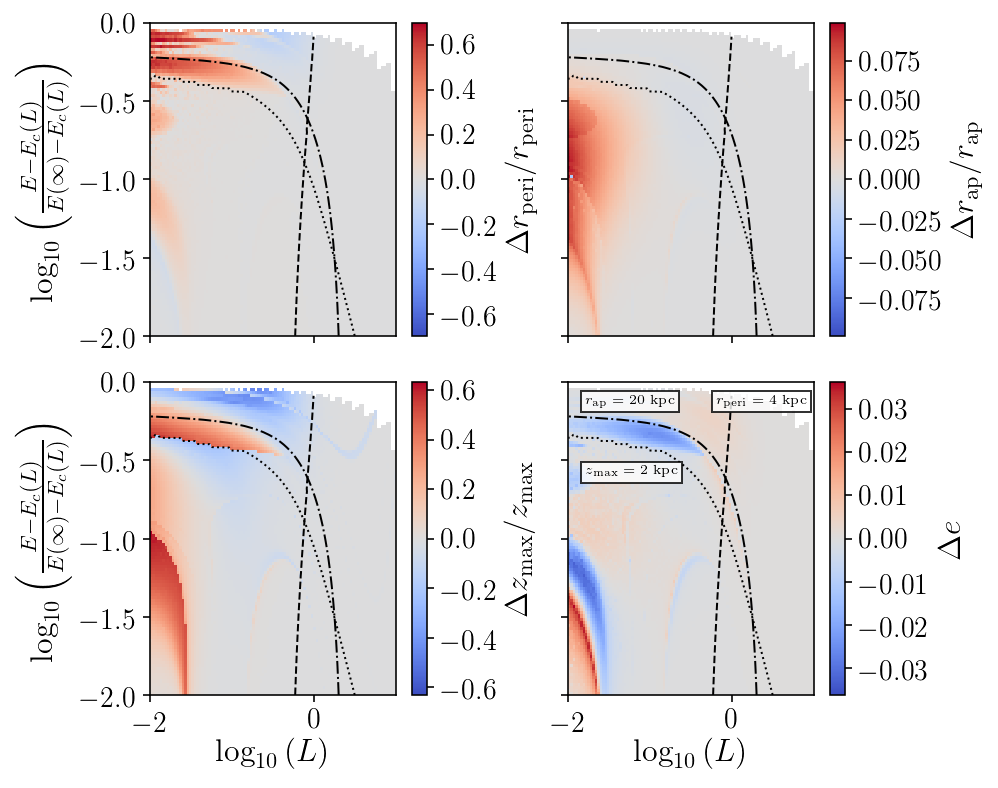

In [4]:
legrid = np.mgrid[-2.:0.:101j,-2:1.:101j]

extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta r_{\mathrm{peri}}/r_{\mathrm{peri}}$',r'$\Delta r_{\mathrm{ap}}/r_{\mathrm{ap}}$',r'$\Delta z_{\mathrm{max}}/z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = (par_int[:,:,i]-par_estd[:,:,i])/par_int[:,:,i]
    else:
        de = par_int[:,:,i]-par_estd[:,:,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,1].text(-0.2,-0.15,r'$r_{\mathrm{peri}} = 4\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[1,1].text(-1.8,-0.6,r'$z_{\mathrm{max}} = 2\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[1,1].text(-1.8,-0.15,r'$r_{\mathrm{ap}} = 20\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')

fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_divergent.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_divergent.png', format='png', dpi=400)

In [5]:
from galpy.potential import rl

rguides = np.empty(31)
for ii,i in enumerate(np.linspace(-2.,1.,31)):
    rguides[ii] = rl(MWPotential2014, 10**i)
np.min(rguides)*8., np.max(rguides)*8.

(0.19421816745757259, 117.26175352318172)

In [6]:
print np.nanpercentile((par_int[:,:,0]-par_estd[:,:,0])/par_int[:,:,0], [25,50,75])
print np.nanpercentile((par_int[:,:,1]-par_estd[:,:,1])/par_int[:,:,1], [25,50,75])
print np.nanpercentile((par_int[:,:,2]-par_estd[:,:,2])/par_int[:,:,2], [25,50,75])
print np.nanpercentile((par_int[:,:,3]-par_estd[:,:,3]), [25,50,75])

[ -6.73386026e-04  -8.12039581e-06   8.00820718e-03]
[ -4.15396689e-04  -2.25462827e-05   3.63617695e-03]
[-0.01913759 -0.00170242  0.00418756]
[ -4.15849835e-04   1.26679913e-05   7.10340688e-04]


In [7]:
print np.nanmean((par_int[:,:,0]-par_estd[:,:,0])/par_int[:,:,0]), np.nanstd((par_int[:,:,0]-par_estd[:,:,0])/par_int[:,:,0])
print np.nanmean((par_int[:,:,1]-par_estd[:,:,1])/par_int[:,:,1]), np.nanstd((par_int[:,:,1]-par_estd[:,:,1])/par_int[:,:,1])
print np.nanmean((par_int[:,:,2]-par_estd[:,:,2])/par_int[:,:,2]), np.nanstd((par_int[:,:,2]-par_estd[:,:,2])/par_int[:,:,2])
print np.nanmean((par_int[:,:,3]-par_estd[:,:,3])), np.nanstd((par_int[:,:,3]-par_estd[:,:,3]))

0.0266803867637 0.0979856234896
0.00713545644335 0.0175537373212
0.0216089668713 0.140319472808
-0.000523401141554 0.00602768852473


## Comparison between estimated and integrated parameters when delta is fixed

/home/astjmack/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "



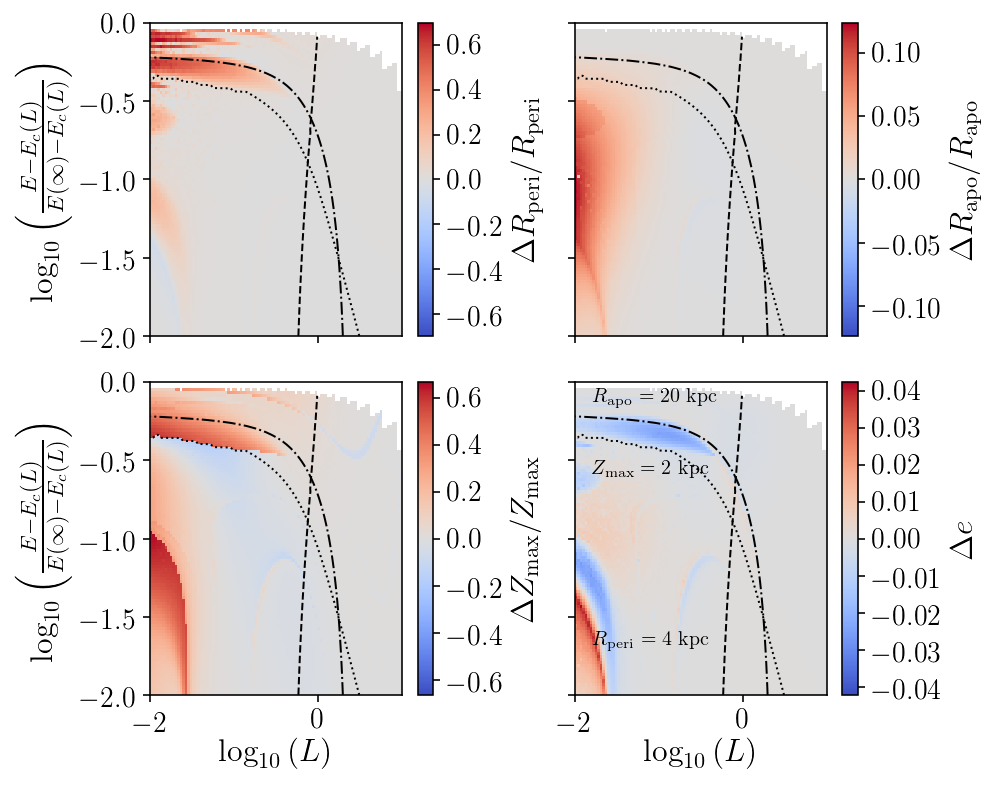

In [8]:
legrid = np.mgrid[-2.:0.:101j,-2:1.:101j]

extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = (par_int[:,:,i]-par_dconst[:,:,i])/par_int[:,:,i]
    else:
        de = par_int[:,:,i]-par_dconst[:,:,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()

## Parameters as a function of log(E) and log(L)

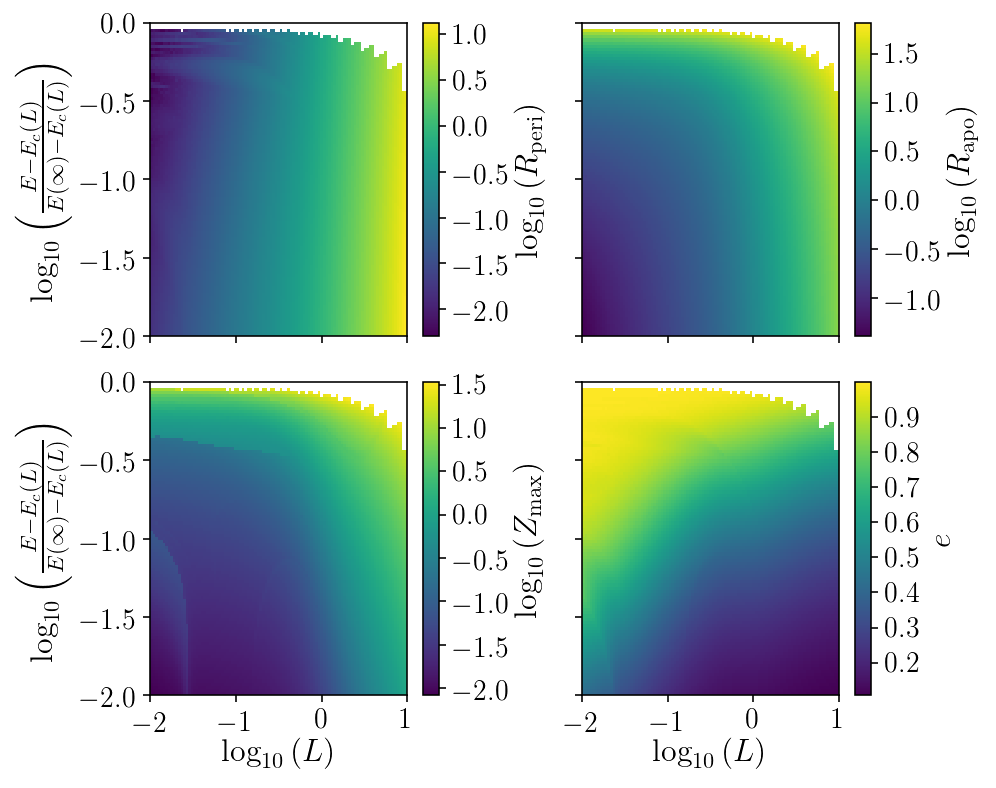

In [9]:
extent = [-2., 1., -2., 0.]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\log_{10}{(R_{\mathrm{peri}})}$',r'$\log_{10}{(R_{\mathrm{apo}})}$',r'$\log_{10}{(Z_{\mathrm{max}})}$',r'$e$']
for i in range(np.shape(par_int)[2]):
    if i < 3:
        de = np.log10(par_int[:,:,i])
    else:
        de = par_int[:,:,i]
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.viridis, extent=extent, aspect='auto')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])


ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()
plt.savefig('../plots/orbit_params_integration.pdf', format='pdf')
plt.savefig('../plots/orbit_params_integration.png', format='png', dpi=400)

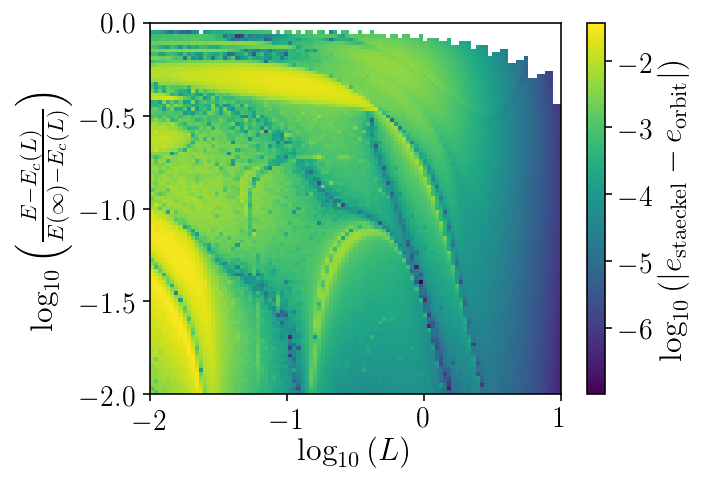

In [10]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.imshow(np.log10(np.rot90(np.fabs(par_estd[:,:,3]-par_int[:,:,3]))), cmap=plt.cm.viridis, extent=extent, aspect='auto')
plt.xlabel(r'$\log_{10}{(L)}$')
plt.ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.colorbar(label=r'$\log_{10}{\left(|e_{\mathrm{staeckel}}-e_{\mathrm{orbit}}|\right)}$', ticks=[-7,-6,-5,-4,-3,-2,-1,0])
fig.tight_layout()

fig.savefig('../plots/orbit_param_comparison_abs.pdf', format='pdf')
fig.savefig('../plots/orbit_param_comparison_abs.png', format='png', dpi=400)

## Scatter plots

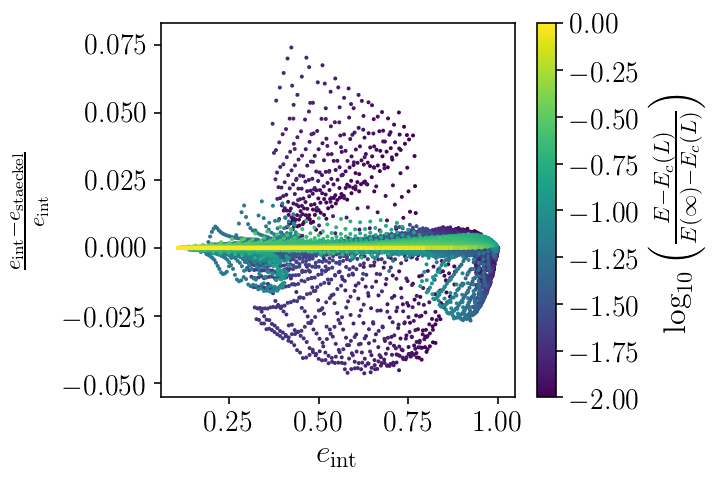

In [11]:
legrid = np.mgrid[-2.:0.:101j,0.01:10.:101j]


fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), (par_int[:,:,3]-par_estd[:,:,3]).ravel()/par_int[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_energy.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_energy.png', format='png', dpi=400)

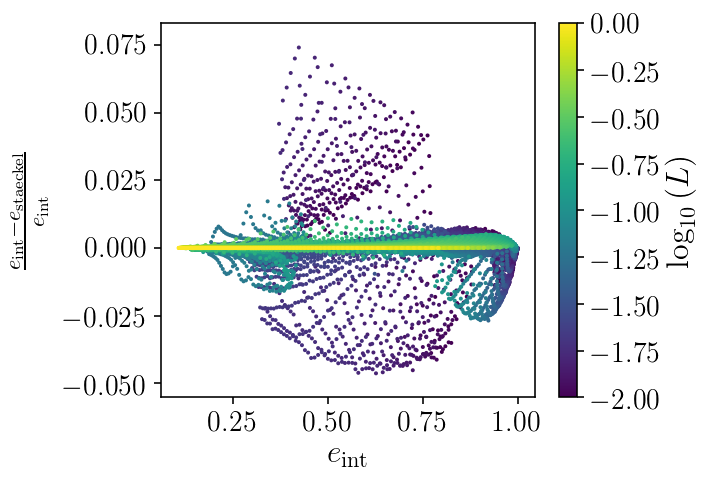

In [12]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), ((par_int[:,:,3]-par_estd[:,:,3])/par_int[:,:,3]).ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(L\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$\frac{e_{\mathrm{int}}-e_{\mathrm{staeckel}}}{e_{\mathrm{int}}}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_scatter_L.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_scatter_L.png', format='png', dpi=400)

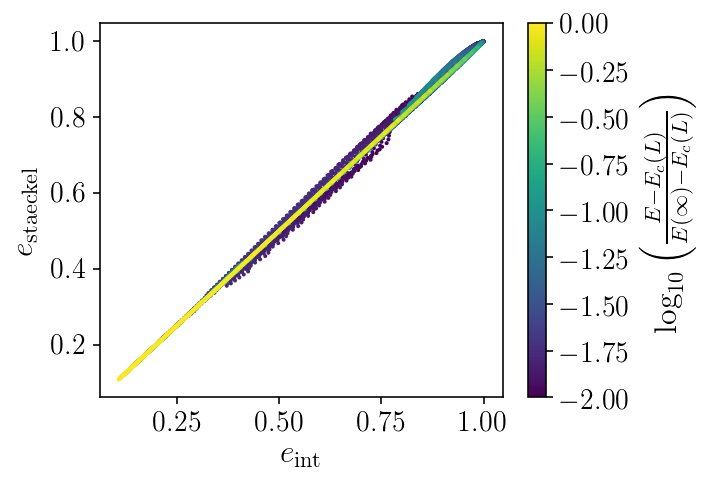

In [13]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,3].ravel(), par_estd[:,:,3].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$e_{\mathrm{int}}$')
plt.ylabel(r'$e_{\mathrm{staeckel}}$')
fig.tight_layout()
plt.savefig('../plots/staeckel_vs_int.pdf', format='pdf')
plt.savefig('../plots/staeckel_vs_int.png', format='png', dpi=400)

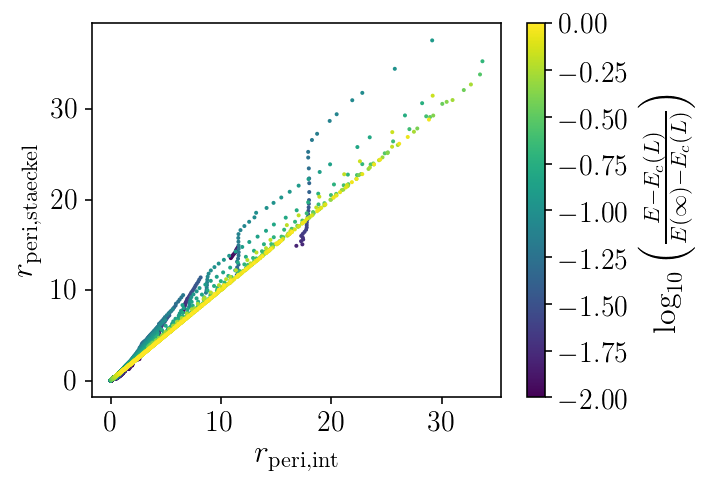

In [16]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.7*columnwidth)
plt.scatter(par_int[:,:,2].ravel(), par_estd[:,:,2].ravel(), s=1., c=legrid[0].ravel(), cmap=plt.cm.viridis)
plt.colorbar(label=r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
plt.xlabel(r'$r_{\mathrm{peri,int}}$')
plt.ylabel(r'$r_{\mathrm{peri,staeckel}}$')
fig.tight_layout()
#plt.savefig('../plots/staeckel_vs_int.pdf', format='pdf')
#plt.savefig('../plots/staeckel_vs_int.png', format='png', dpi=400)

In [17]:
print np.nanstd((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())
print np.nanmean((par_estd[:,:,3]-par_int[:,:,3]).ravel()/par_int[:,:,3].ravel())

0.00929309454892
0.00063626633539


## An example orbit - demonstrating method

In [19]:
#initialise and integrate an orbit and estimate the parameters
o = orbit_atEL(-0.8,-0.2, ts=numpy.linspace(0.,350.,10000))

ts=numpy.linspace(0.,350.,10000)
Rs = o.R(ts)
Zs = o.z(ts)

delta = orbit_helper.estimate_delta(o, ts=ts, pot=MWPotential2014)
param = orbit_helper.estimate_orbit_params(o,pot=MWPotential2014, delta=delta)
aASS = actionAngleStaeckelSingle(o,pot=MWPotential2014,delta=delta)
umin, umax= aASS.calcUminUmax()


/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/util/bovy_coords.py:1773: RuntimeWarning: invalid value encountered in arccosh
  u= sc.arccosh(coshu)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



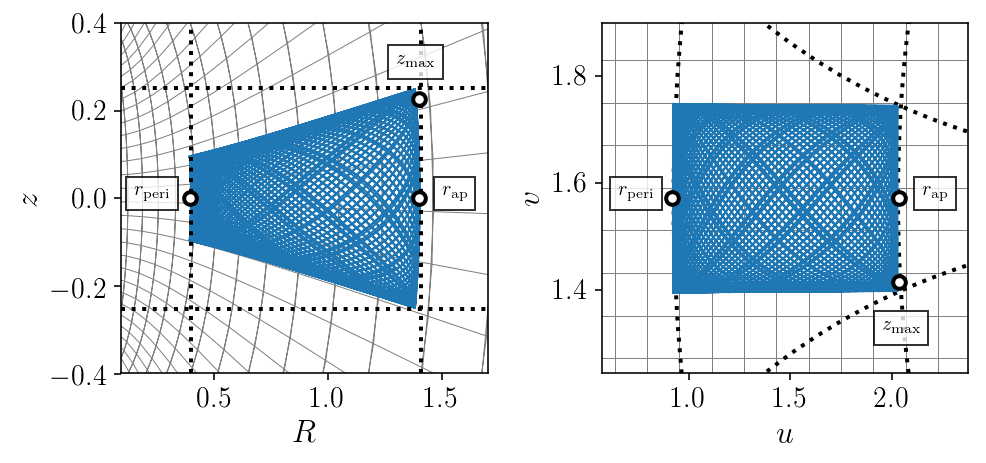

In [20]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth, columnwidth)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=delta)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=delta)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=delta)
uv_grid = np.mgrid[0.:4*np.pi:80j, 0.:4*np.pi:80j]
delta = delta
RZ = bovy_coords.uv_to_Rz(uv_grid[0].ravel(), uv_grid[1].ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)
#R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])
#Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])
ax[0].plot(R, Z, color='Gray', lw=0.5)
ax[0].plot(R.T, Z.T, color='Gray', lw=0.5)
ax[0].plot(o.R(ts), o.z(ts))
ax[0].set_xlim(np.min(o.R(ts))-0.3, np.max(o.R(ts))+0.3)
ax[0].set_ylim(np.min(o.z(ts))-0.15, np.max(o.z(ts))+0.15)
ax[0].set_xlabel(r'$R$')
ax[0].set_ylabel(r'$z$')
ax[0].axvline(param[0], lw=2., c='Black', linestyle='dotted')
ax[0].axvline(param[1], lw=2., c='Black', linestyle='dotted')
ax[0].axhline(param[2], lw=2., c='Black', linestyle='dotted')
ax[0].axhline(-param[2], lw=2., c='Black', linestyle='dotted')

RZ = bovy_coords.Rz_to_uv(R.ravel(), Z.ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)

zmax_R = np.linspace(0.,5.,40)
zmax_z = np.ones(40)*param[2]
rperi_R = np.ones(40)*param[0]
rperi_z = np.linspace(-1,1,40)
rapo_R = np.ones(40)*param[1]
rapo_z = np.linspace(-1,1,40)
ax[1].plot(R, Z, color='Gray', lw=0.5)
ax[1].plot(R.T, Z.T, color='Gray', lw=0.5)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, zmax_z,delta=delta)
ax[1].plot(zmax_u, zmax_v, lw=2., c='Black', linestyle='dotted')
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, -zmax_z,delta=delta)
ax[1].plot(zmax_u, zmax_v, lw=2., c='Black', linestyle='dotted')
rperi_u, rperi_v = bovy_coords.Rz_to_uv(rperi_R, rperi_z,delta=delta)
ax[1].plot(rperi_u, rperi_v, lw=2., c='Black', linestyle='dotted')
rapo_u, rapo_v = bovy_coords.Rz_to_uv(rapo_R, rapo_z,delta=delta)
ax[1].plot(rapo_u, rapo_v, lw=2., c='Black', linestyle='dotted')
ax[1].plot(u, v)
ax[1].set_xlim(np.min(u)-0.35, np.max(u)+0.35)
ax[1].set_ylim(np.min(v)-0.15, np.max(v)+0.15)
ax[1].set_xlabel(r'$u$')
ax[1].set_ylabel(r'$v$')

fig.tight_layout()

ax[0].text(0.15,0.,r'$r_\mathrm{peri}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[0].text(1.5,0.,r'$r_\mathrm{ap}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[0].text(1.3,0.3,r'$z_\mathrm{max}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})

ax[0].scatter(o.rap(analytic=True), o.zmax(analytic=True), facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)
ax[0].scatter(o.rperi(analytic=True), 0., facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)
ax[0].scatter(o.rap(analytic=True), 0., facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)

uvmax = bovy_coords.Rz_to_uv(o.rap(analytic=True), o.zmax(analytic=True), delta=delta)
uperi, v_0 = bovy_coords.Rz_to_uv(o.rperi(analytic=True), 0., delta=delta)

ax[1].text(0.65,np.pi/2.,r'$r_\mathrm{peri}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[1].text(2.15,np.pi/2.,r'$r_\mathrm{ap}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})
ax[1].text(1.95,1.32,r'$z_\mathrm{max}$', bbox={'facecolor':'White', 'alpha':0.8, 'pad':4})

ax[1].scatter(uvmax[0], uvmax[1], facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)
ax[1].scatter(uperi, v_0, facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)
ax[1].scatter(uvmax[0], v_0, facecolor='White', edgecolor='Black', lw=2., s=40, zorder=10)
#plt.savefig('../plots/example_orbit.pdf', format='pdf', dpi=400)
#plt.savefig('../plots/example_orbit.png', format='png', dpi=400)




## looking at odd orbits

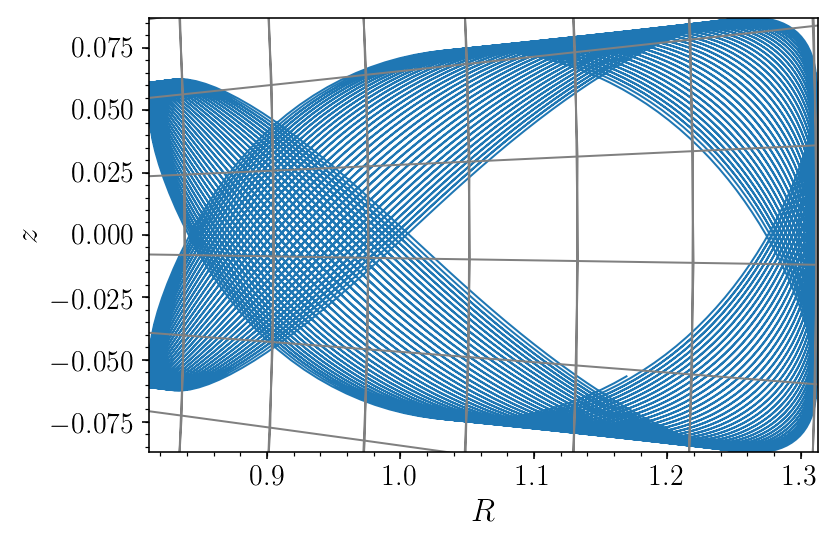

In [21]:
o = orbit_atEL(-1.55,-0., ts=numpy.linspace(0.,350.,10000))

ts=numpy.linspace(0.,30.,10000)
Rs = o.R(ts)
Zs = o.z(ts)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=0.375)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=0.375)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=0.375)

o.plot()
uv_grid = np.mgrid[0.:4*np.pi:180j, 0.:4*np.pi:180j]
delta = 0.375
R = delta*np.sinh(uv_grid[0])*np.sin(uv_grid[1])
Z = delta*np.cosh(uv_grid[0])*np.cos(uv_grid[1])
plt.plot(R, Z, color='Gray')
plt.plot(R.T, Z.T, color='Gray')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
#plt.xlim(xlim[0]-0.2,xlim[1]+0.2)
#plt.ylim(ylim[0]-0.2,ylim[1]+0.2)
#plt.scatter(maxR, maxZ, c='Red')
#plt.scatter(np.sqrt(maxR**2+maxZ**2), 0., c='Red')

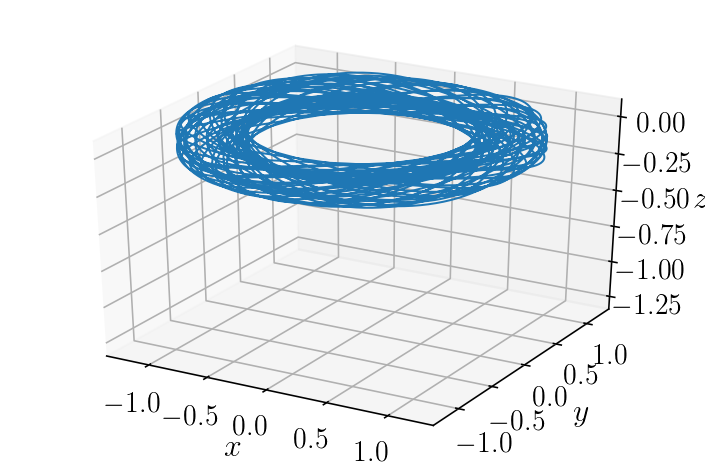

In [22]:
o.plot3d()

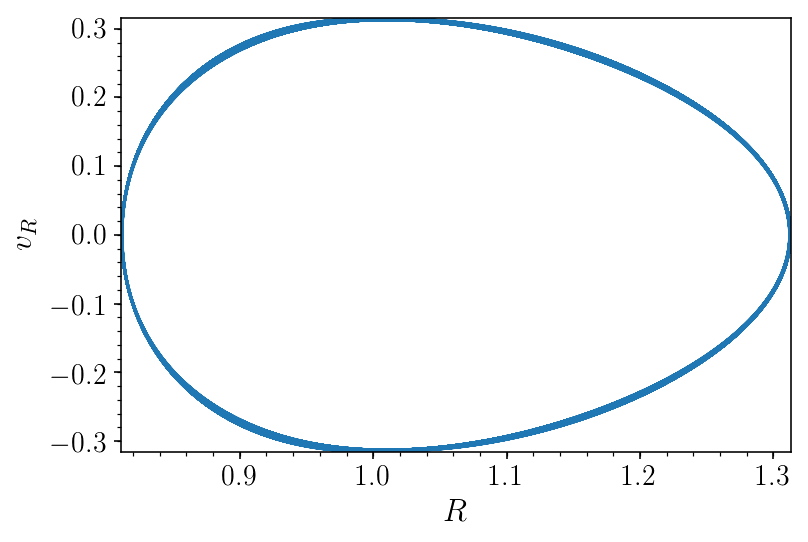

In [23]:
o.plot(d1='R', d2='vR')

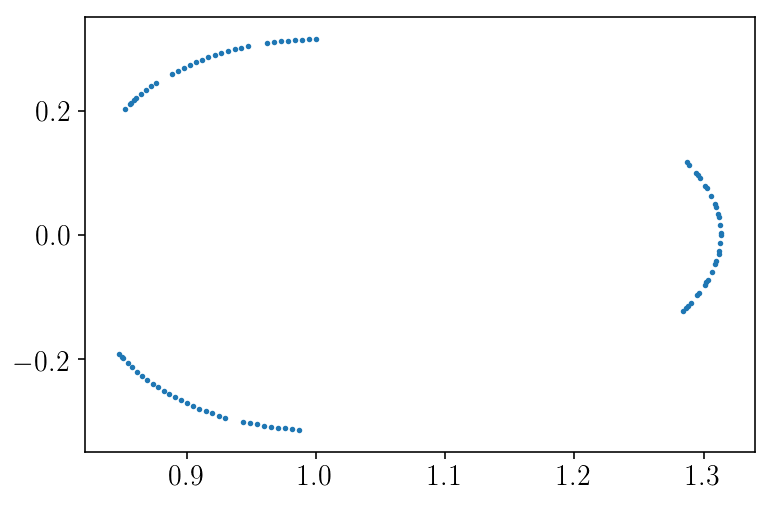

In [24]:
its = numpy.linspace(0.,300.,10000)
sectRs,sectvRs=surface_section(o.R(its),o.z(its),o.vR(its)) 
plt.scatter(sectRs,sectvRs, s=3.)




## Looking at R-vR vs u-p_u - understanding the method

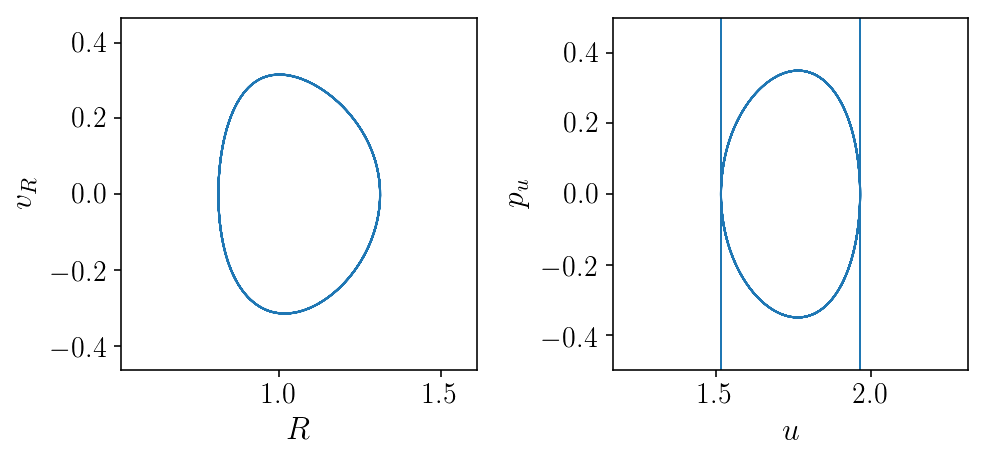

In [25]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth, columnwidth)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=delta)
pu, pv = bovy_coords.vRvz_to_pupv(o.vR(ts),o.vz(ts),o.R(ts),o.z(ts),delta=delta)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=delta)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=delta)
uv_grid = np.mgrid[0.:4*np.pi:80j, 0.:4*np.pi:80j]
delta = delta
RZ = bovy_coords.uv_to_Rz(uv_grid[0].ravel(), uv_grid[1].ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)
ax[0].plot(o.R(ts), o.vR(ts))
ax[0].set_xlim(np.min(o.R(ts))-0.3, np.max(o.R(ts))+0.3)
ax[0].set_ylim(np.min(o.vR(ts))-0.15, np.max(o.vR(ts))+0.15)
ax[0].set_xlabel(r'$R$')
ax[0].set_ylabel(r'$v_R$')
RZ = bovy_coords.Rz_to_uv(R.ravel(), Z.ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)

zmax_R = np.linspace(0.,5.,40)
zmax_z = np.ones(40)*param[2]
rperi_R = np.ones(40)*param[0]
rperi_z = np.linspace(-1,1,40)
rapo_R = np.ones(40)*param[1]
rapo_z = np.linspace(-1,1,40)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, zmax_z,delta=delta)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, -zmax_z,delta=delta)
rperi_u, rperi_v = bovy_coords.Rz_to_uv(rperi_R, rperi_z,delta=delta)
rapo_u, rapo_v = bovy_coords.Rz_to_uv(rapo_R, rapo_z,delta=delta)
ax[1].plot(u, pu)
ax[1].set_xlim(np.min(u)-0.35, np.max(u)+0.35)
ax[1].set_ylim(np.min(pu)-0.15, np.max(pu)+0.15)
ax[1].set_xlabel(r'$u$')
ax[1].set_ylabel(r'$p_u$')

fig.tight_layout()
ax[1].axvline(maxu)
ax[1].axvline(minu)
uvmax = bovy_coords.Rz_to_uv(o.rap(), o.zmax(), delta=delta)
uperi, v_0 = bovy_coords.Rz_to_uv(o.rperi(), 0., delta=delta)


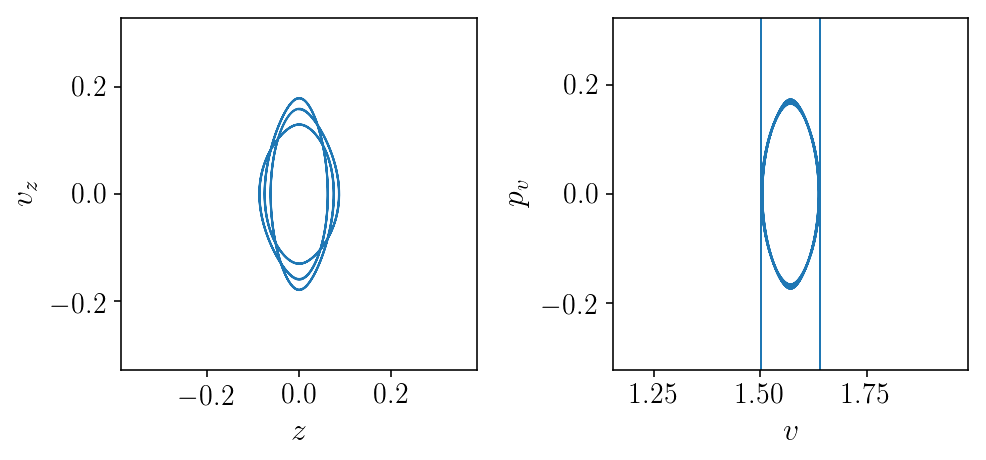

In [26]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(textwidth, columnwidth)
u, v = bovy_coords.Rz_to_uv(Rs, Zs, delta=delta)
pu, pv = bovy_coords.vRvz_to_pupv(o.vR(ts),o.vz(ts),o.R(ts),o.z(ts),delta=delta)
maxu, minu = np.max(u), np.min(u)
maxv, minv = np.max(v), np.min(v)
maxR, maxZ = bovy_coords.uv_to_Rz(maxu,minv,delta=delta)
minR, minZ = bovy_coords.uv_to_Rz(minu,maxv,delta=delta)
uv_grid = np.mgrid[0.:4*np.pi:80j, 0.:4*np.pi:80j]
delta = delta
RZ = bovy_coords.uv_to_Rz(uv_grid[0].ravel(), uv_grid[1].ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)
ax[0].plot(o.z(ts), o.vz(ts))
ax[0].set_xlim(np.min(o.z(ts))-0.3, np.max(o.z(ts))+0.3)
ax[0].set_ylim(np.min(o.vz(ts))-0.15, np.max(o.vz(ts))+0.15)
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$v_z$')
RZ = bovy_coords.Rz_to_uv(R.ravel(), Z.ravel(), delta=delta)
R = RZ[0].reshape(80,80)
Z = RZ[1].reshape(80,80)

zmax_R = np.linspace(0.,5.,40)
zmax_z = np.ones(40)*param[2]
rperi_R = np.ones(40)*param[0]
rperi_z = np.linspace(-1,1,40)
rapo_R = np.ones(40)*param[1]
rapo_z = np.linspace(-1,1,40)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, zmax_z,delta=delta)
zmax_u, zmax_v = bovy_coords.Rz_to_uv(zmax_R, -zmax_z,delta=delta)
rperi_u, rperi_v = bovy_coords.Rz_to_uv(rperi_R, rperi_z,delta=delta)
rapo_u, rapo_v = bovy_coords.Rz_to_uv(rapo_R, rapo_z,delta=delta)
ax[1].plot(v, pv)
ax[1].set_xlim(np.min(v)-0.35, np.max(v)+0.35)
ax[1].set_ylim(np.min(pv)-0.15, np.max(pv)+0.15)
ax[1].set_xlabel(r'$v$')
ax[1].set_ylabel(r'$p_v$')

fig.tight_layout()
ax[1].axvline(maxv)
ax[1].axvline(minv)
uvmax = bovy_coords.Rz_to_uv(o.rap(), o.zmax(), delta=delta)
uperi, v_0 = bovy_coords.Rz_to_uv(o.rperi(), 0., delta=delta)



In [27]:
o.animate(width=800,
          d1=['R',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=0.45)[0]],
          d2=['vR',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=0.45)[0]],
         xlabel=[None,'u'],ylabel=[None,'p_u'])

In [28]:
o.animate(width=800,
          d1=['z',lambda t: bovy_coords.Rz_to_uv(o.R(t),o.z(t),delta=0.45)[1]],
          d2=['vz',lambda t: bovy_coords.vRvz_to_pupv(o.vR(t),o.vz(t),o.R(t),o.z(t),delta=0.45)[1]],
         xlabel=[None,'v'],ylabel=[None,'p_v'])

# Testing the estimation on a smaller grid, including varying velocity

**Miss the cell below to avoid the computation!**

In [ ]:
log10Lmin, log10Lmax= -0.5, 0.5
log10Emin, log10Emax= -2., -0.5
xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
xs = numpy.linspace(xmin, xmax, nx)
#Integration times
i_ts= numpy.linspace(0.,20.,1001)
#empty arrays for outputs: estimated deltas, parameters estimated with a constant delta, parameters estimated with
#an estimated delta, and parameters calculated from an orbital integration.
deltas= numpy.empty((nL,nE,nx))
par_dconst = numpy.empty((nL,nE,nx,4))
par_estd = numpy.empty((nL,nE,nx,4))
par_int = numpy.empty((nL,nE,nx,4))

for ii in tqdm_notebook(range(nL)):
    for jj in tqdm_notebook(range(nE)):
        for kk in tqdm_notebook(range(nx)):
            o = orbit_helper.orbit_at_E_L(Es[jj], Ls[ii], x=xs[kk], pot=MWPotential2014)        
            #estimate delta by doing a short integration
            deltas[ii,jj,kk]= orbit_helper.estimate_delta(o, ts=i_ts, pot=MWPotential2014)
            #estimate the azimuthal period
            Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            #return nan values if Tp is not returned by galpy
            if not np.isfinite(Tp):
                par_dconst[ii,jj,kk] = np.ones(4)*np.nan
                par_estd[ii,jj,kk] = np.ones(4)*np.nan
                par_int[ii,jj,kk] = np.ones(4)*np.nan
                continue
            ts= numpy.arange(0.,20.*Tp,0.01) # integrate for 20 azimuthal periods, with fixed time step (is 0.01 good enough)
            o.integrate(ts,MWPotential2014,method='symplec4_c')
            #save integration parameters
            par_int[ii,jj,kk] = np.array([o.rperi(),o.rap(),o.zmax(),o.e()])
            #calculate staeckel approx estimation using constant delta and estimated delta
            par_estd[ii,jj,kk] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=deltas[ii,jj,kk])
            par_dconst[ii,jj,kk] = orbit_helper.estimate_orbit_params(o, pot=MWPotential2014, delta=0.4)


    

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:915: RuntimeWarning: invalid value encountered in double_scalars
  use_physical=False)))/evaluateRzderivs(pot,R[ii],z[ii],use_physical=False)) for ii in range(len(R))])

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in less
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/galpy-1.3.dev0-py2.7-linux-x86_64.egg/galpy/actionAngle_src/actionAngleStaeckel.py:916: RuntimeWarning: invalid value encountered in greater
  indx= (delta2 < 0.)*(delta2 > -10.**-10.)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/astjmack/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py

In [104]:
#store results
obj = [par_int ,par_dconst, par_estd, deltas]
with open('../sav/params_estimated_staeckel_withV_zoomed.dat', 'w') as f:
    pickle.dump(obj, f)

In [29]:
with open('../sav/params_estimated_staeckel_withV_zoomed.dat', 'r') as f:
    obj = pickle.load(f)
par_int ,par_dconst, par_estd, deltas = obj

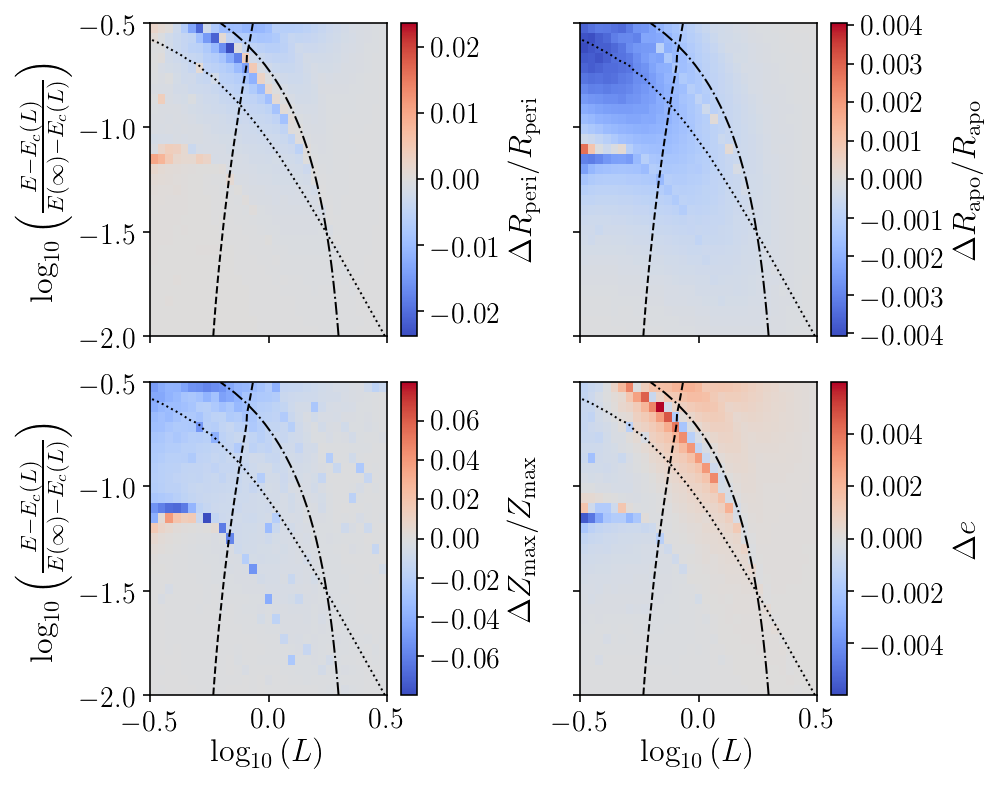

In [30]:
legrid = np.mgrid[-2.:-0.5:31j,-0.5:0.5:31j]

xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
xs = numpy.linspace(xmin, xmax, nx)
xi = np.argmin(np.fabs(xs-4./5.))
extent = [-0.5, 0.5, -2, -0.5]
fig, ax = plt.subplots(2,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.8*textwidth)
labels = [r'$\Delta R_{\mathrm{peri}}/R_{\mathrm{peri}}$',r'$\Delta R_{\mathrm{apo}}/R_{\mathrm{apo}}$',r'$\Delta Z_{\mathrm{max}}/Z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[3]):
    if i < 3:
        de = (par_int[:,:,xi,i]-par_estd[:,:,xi,i])/par_int[:,:,xi,i]
    else:
        de = par_int[:,:,xi,i]-par_estd[:,:,xi,i]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    plt.colorbar(s, label=labels[i], ax=ax.ravel()[i])

#ax[1,1].text(-1.8,-1.7,r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
#ax[1,1].text(-1.8,-0.6,r'$Z_{\mathrm{max}} = 2\ \mathrm{kpc}$')
#ax[1,1].text(-1.8,-0.15,r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
ax[1,0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1,1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[1,0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
ax[0,0].legend(frameon=False, loc=3, fontsize='x-small')
fig.tight_layout()

In [31]:
from galpy.potential import rl

rguides = np.empty(32)
for ii,i in enumerate(np.linspace(-0.5,0.5,31)):
    rguides[ii] = rl(MWPotential2014, 10**i)
np.min(rguides)*8., np.max(rguides)*8.

(0.0, 29.456752712815408)

In [32]:
print np.median((par_int[:,:,xi,2]-par_estd[:,:,xi,2])/par_int[:,:,xi,2])
print np.median((par_int[:,:,xi,3]-par_estd[:,:,xi,3]))

-0.00252850297595
2.88482709685e-05


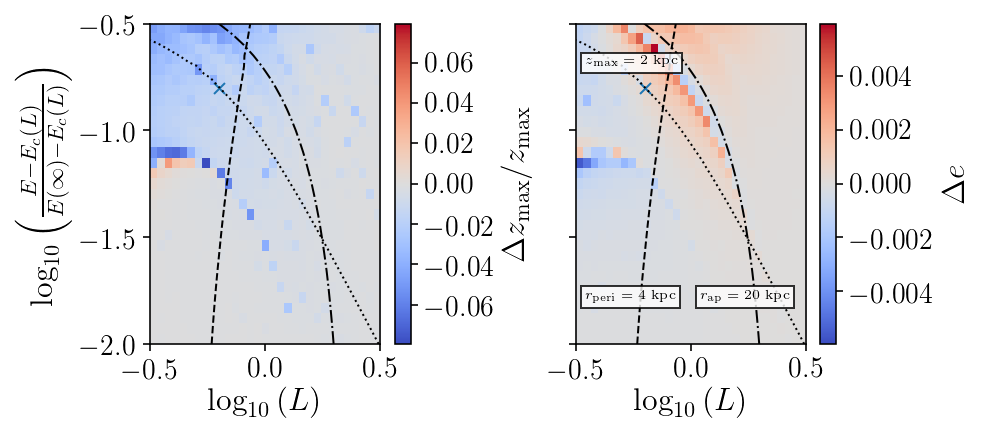

In [33]:
legrid = np.mgrid[-2.:-0.5:31j,-0.5:0.5:31j]

xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
xs = numpy.linspace(xmin, xmax, nx)
xi = np.argmin(np.fabs(xs-4./5.))
extent = [-0.5, 0.5, -2, -0.5]
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
fig.set_size_inches(textwidth, 0.45*textwidth)
labels = [r'$\Delta r_{\mathrm{peri}}/r_{\mathrm{peri}}$',r'$\Delta r_{\mathrm{ap}}/r_{\mathrm{ap}}$',r'$\Delta z_{\mathrm{max}}/z_{\mathrm{max}}$',r'$\Delta e$']

for i in range(np.shape(par_int)[3]-2):
    if i < 1:
        de = (par_int[:,:,xi,i+2]-par_estd[:,:,xi,i+2])/par_int[:,:,xi,i+2]
    else:
        de = par_int[:,:,xi,i+2]-par_estd[:,:,xi,i+2]
    lim = np.nanmax(np.fabs(de))
    s = ax.ravel()[i].imshow(np.rot90(de), cmap=plt.cm.coolwarm, extent=extent, aspect='auto', vmin=-lim, vmax=lim)
    rpCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,0]), levels = [4./8.], colors='Black', linestyles='dashed', label=r'$R_{\mathrm{peri}} = 4\ \mathrm{kpc}$')
    raCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,1]), levels = [20./8.], colors='Black', linestyles='dashdot', label=r'$R_{\mathrm{apo}} = 20\ \mathrm{kpc}$')
    zmCS = ax.ravel()[i].contour(legrid[1][::-1], legrid[0][::-1],np.rot90(par_int[:,:,xi,2]), levels = [2./8.], colors='Black', linestyles='dotted', label=r'$Z_{\mathrm{max}} = 4\ \mathrm{kpc}$')
    ax.ravel()[i].scatter(-0.2,-0.8,s=30., marker='x')
    plt.colorbar(s, label=labels[i+2], ax=ax.ravel()[i])

ax[1].text(-0.46,-1.8,r'$r_{\mathrm{peri}} = 4\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[1].text(-0.46,-0.7,r'$z_{\mathrm{max}} = 2\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[1].text(0.04,-1.8,r'$r_{\mathrm{ap}} = 20\ \mathrm{kpc}$', fontsize=7,bbox={'facecolor':'White', 'alpha':0.8, 'pad':2})
ax[0].set_xlabel(r'$\log_{10}{(L)}$')
ax[1].set_xlabel(r'$\log_{10}{(L)}$')
ax[0].set_ylabel(r'$\log_{10}{\left(\frac{E-E_c(L)}{E(\infty)-E_c(L)}\right)}$')
fig.tight_layout()
plt.savefig('../plots/orbit_param_comparison_zmax_e_panels.pdf', format='pdf')
plt.savefig('../plots/orbit_param_comparison_zmax_e_panels.png', format='png', dpi=400)


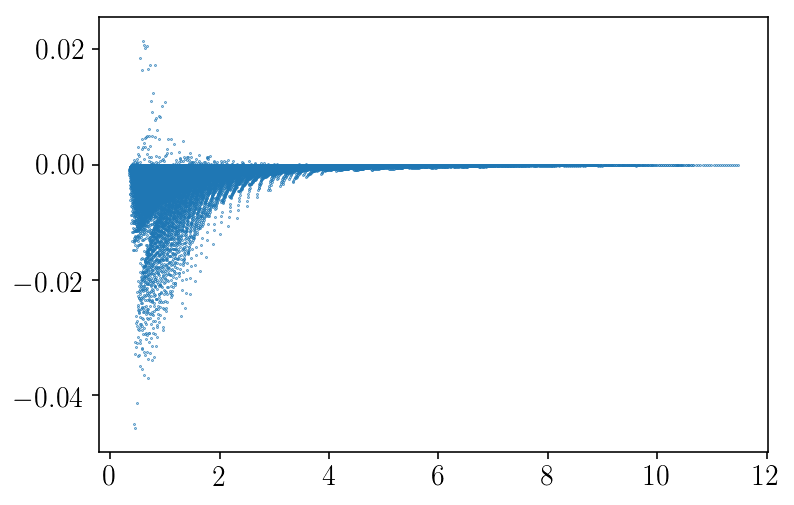

In [34]:
plt.scatter(par_int[:,:,:,1].ravel(), (par_int[:,:,:,1].ravel()-par_estd[:,:,:,1].ravel())/par_int[:,:,:,1].ravel(), s=0.1)

# Parameters along the orbits, as a function of angle

In [35]:
log10Lmin, log10Lmax= -0.5, 0.5
log10Emin, log10Emax= -2., -0.5
xmin, xmax = 0., 1.
nL, nE, nx= 31,31,31
Ls= numpy.linspace(log10Lmin,log10Lmax,nL)
Es= numpy.linspace(log10Emin,log10Emax,nL)
xs = numpy.linspace(xmin, xmax, nx)
o = orbit_atEL(-1.5,-0.0, x= 4./5.,  ts=numpy.linspace(0.,300.,10000))

est_delta = orbit_helper.estimate_delta(o)
o = orbit_atEL(-1.5,-0.0, x= 4./5.,  ts=numpy.linspace(0.,300.,10000))


ts=numpy.linspace(0.,30.,10000)

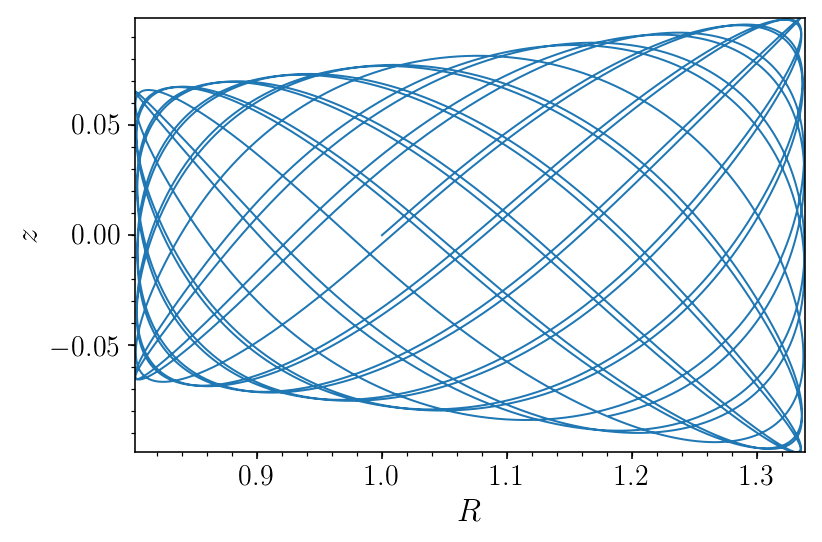

In [36]:
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,c=True)
aR,ap,az,OR,Op,Oz= aAS.actionsFreqs(o)
Tz = 2*np.pi/Oz



Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=est_delta)
    
ts= numpy.arange(0.,10.*Tp,0.001)
t = orbit_helper.params_along_orbit(o, ts, delta=est_delta)
JR,E,Jz,OR,Op,Oz,aR,ap,az= aAS.actionsFreqsAngles(o.R(ts),o.vR(ts), o.vT(ts), o.z(ts), o.vz(ts),o.phi(ts))

o.plot()

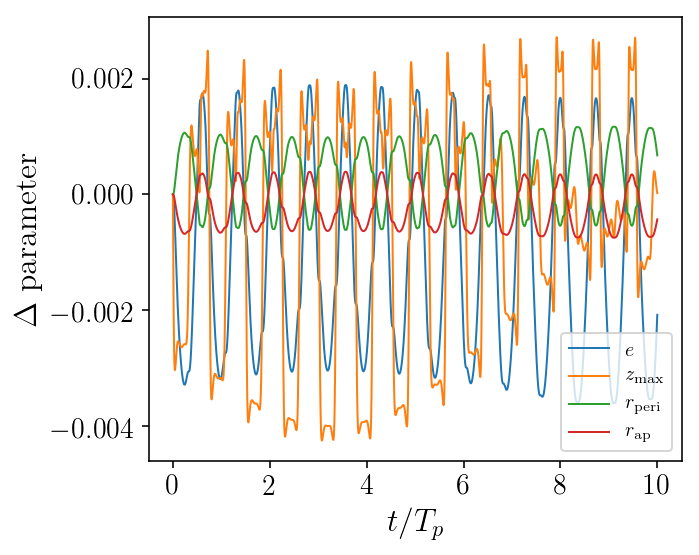

In [43]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.8*columnwidth)

labels = [r'$e$', r'$z_{\mathrm{max}}$', r'$r_{\mathrm{peri}}$', r'$r_{\mathrm{ap}}$']
for i in range(len(t)):
    pao = (t[i]-t[i][0])/t[i][0]
    plt.plot(ts/Tp,pao, label=labels[i])
plt.legend()
plt.xlabel(r'$t/T_{p}$')
plt.ylabel(r'$\Delta\ \mathrm{parameter}$')
fig.tight_layout()
#plt.savefig('../plots/param_along_orbit_logEm1p5_logLm0p0.pdf', format='pdf')
#plt.savefig('../plots/param_along_orbit_logEm1p5_logLm0p0.png', format='png')

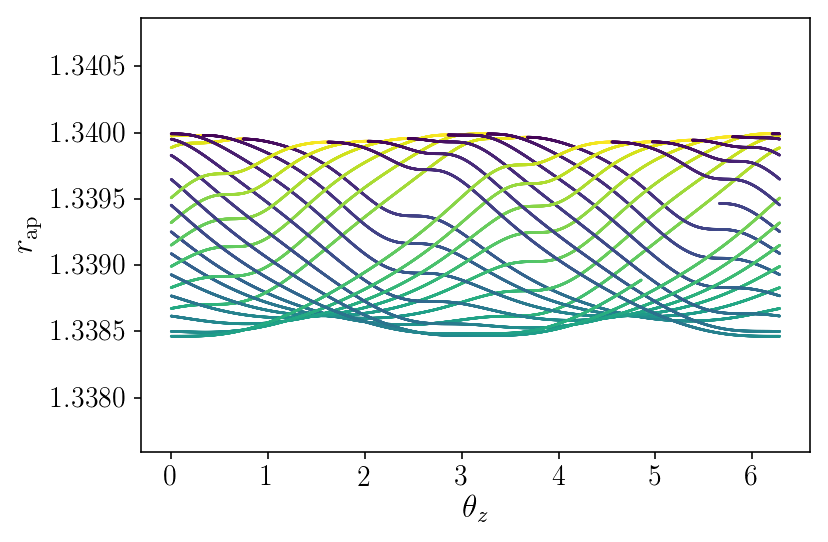

In [47]:
i = 3
plt.scatter(az, t[i], s=0.1, c=aR)
plt.ylabel(labels[i])
plt.xlabel(r'$\theta_{z}$')

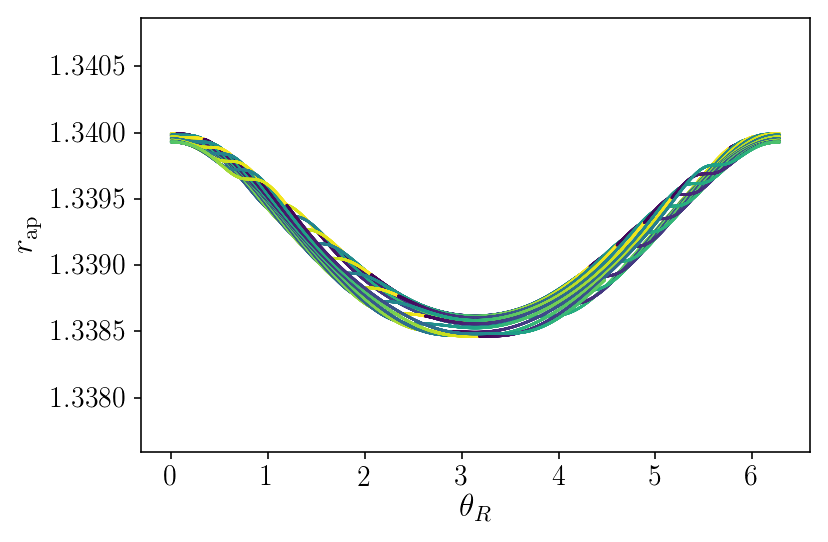

In [48]:
i = 3
plt.scatter(aR, t[i], s=0.1, c=az)
plt.ylabel(labels[i])
plt.xlabel(r'$\theta_{R}$')

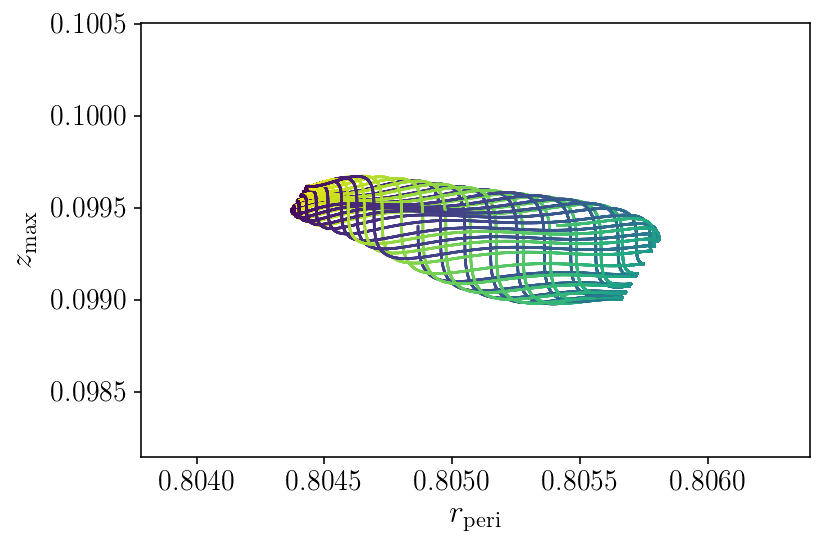

In [49]:
i = 1
plt.scatter(t[2], t[i], s=0.1, c=aR)
plt.ylabel(labels[i])
plt.xlabel(labels[2])

TypeError: ylabel() takes at least 1 argument (0 given)

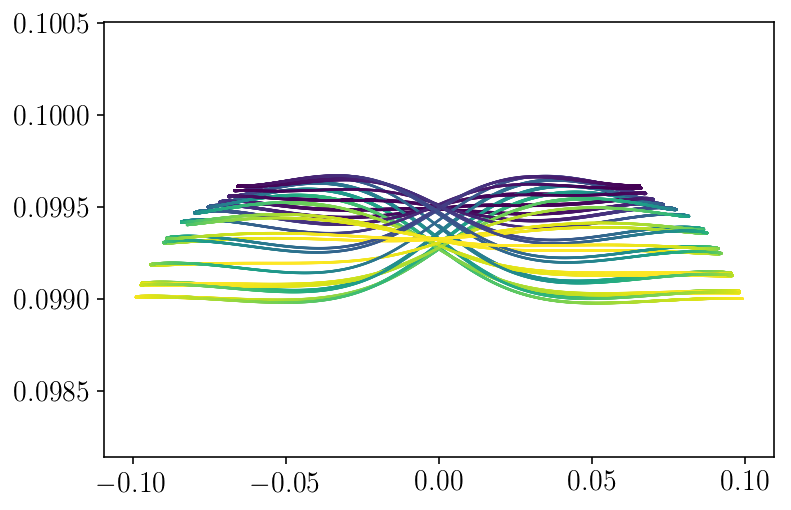

In [50]:
i = 1
plt.scatter(o.z(ts), t[i], s=0.1, c=o.R(ts))
plt.ylabel()

## Comparing with Dierickx et al. (2010)

Code below compares the estimation of orbital eccentricity of our method with that found by Dierickx et al. (2010), and also by galpy's orbit integration.

In [431]:
dierickx = ascii.read('../sav/dierickx_2010/table2.dat', readme='../sav/dierickx_2010/ReadMe')

In [432]:
# *np.cos(dierickx['DEdeg']*(np.pi/180.))
vxvv = np.dstack([dierickx['RAdeg'], dierickx['DEdeg'], dierickx['Dist']/1e3, dierickx['pmRA'], dierickx['pmDE'], dierickx['HRV']])[0]
ro, vo, zo = 8., 220., 0.025
ra, dec= vxvv[:,0], vxvv[:,1]
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]
rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)

vsolar= np.array([-10.1,4.0,6.7])
vsun= np.array([0.,1.,0.,])+vsolar/vo

X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
vsun= np.array([0.,1.,0.,])+vsolar/vo
Rphiz= bovy_coords.XYZ_to_galcencyl(X,Y,Z,Zsun=zo/ro)
vRvTvz= bovy_coords.vxvyvz_to_galcencyl(vx,vy,vz,Rphiz[:,0],Rphiz[:,1],Rphiz[:,2],vsun=vsun,Xsun=1.,Zsun=zo/ro,galcen=True)


In [433]:
t_vxvv = np.dstack([dierickx['RAdeg'], dierickx['DEdeg'], dierickx['Dist']/1e3, dierickx['pmRA'], dierickx['pmDE'], dierickx['HRV']])[0]
ts= np.linspace(0.,20.,10000)
lp= LogarithmicHaloPotential(normalize=1.)

In [25]:
e_ana = numpy.zeros(len(t_vxvv))
e_int = numpy.zeros(len(t_vxvv))
for i in tqdm_notebook(range(len(t_vxvv))):
    try:
        orbit = Orbit(t_vxvv[i], radec=True, vo=220., ro=8.)
        e_ana[i] = orbit.e(analytic=True, pot=lp, c=True)
    except UnboundError:
        e_ana[i] = np.nan
    orbit.integrate(ts, lp)
    e_int[i] = orbit.e(analytic=False)
    

### Comparing integrated and analytic estimates

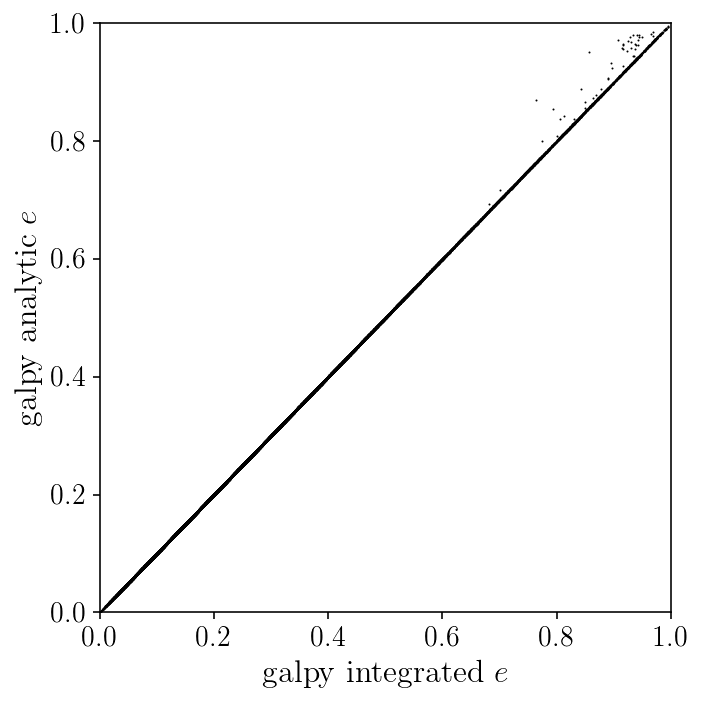

In [55]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.scatter(e_int, e_ana,  s=1, color='Black', lw=0.)
plt.xlabel(r'$\mathrm{galpy\ integrated}\ e$')
plt.ylabel(r'$\mathrm{galpy\ analytic}\ e$')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
fig.tight_layout()
plt.savefig('../plots/dierickx-integratedeanalytice.png', format='png', dpi=200)

### The eccentricity distribution

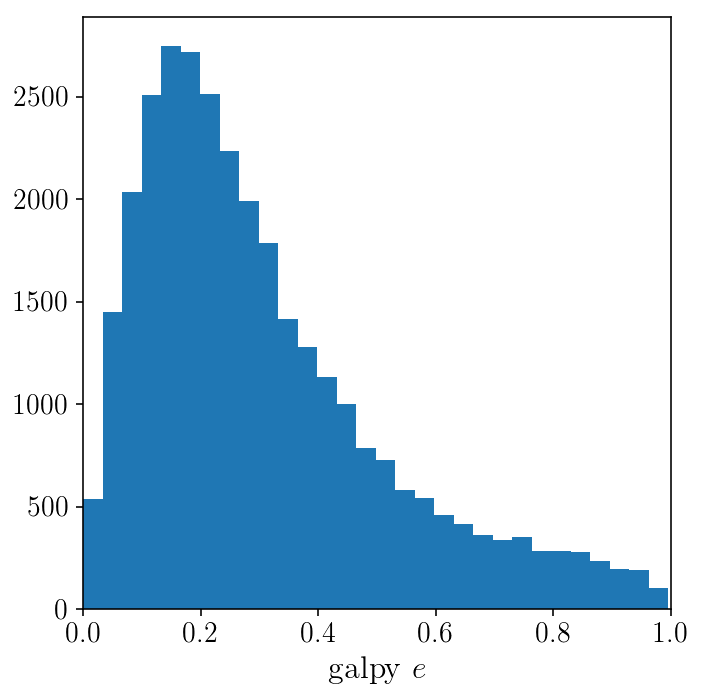

In [56]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.hist(e_int, bins=30)
plt.xlim(0.,1.)
plt.xlabel(r'$\mathrm{galpy}\ e$')
fig.tight_layout()
plt.savefig('../plots/dierickx-integratedehist.png', format='png', dpi=200)


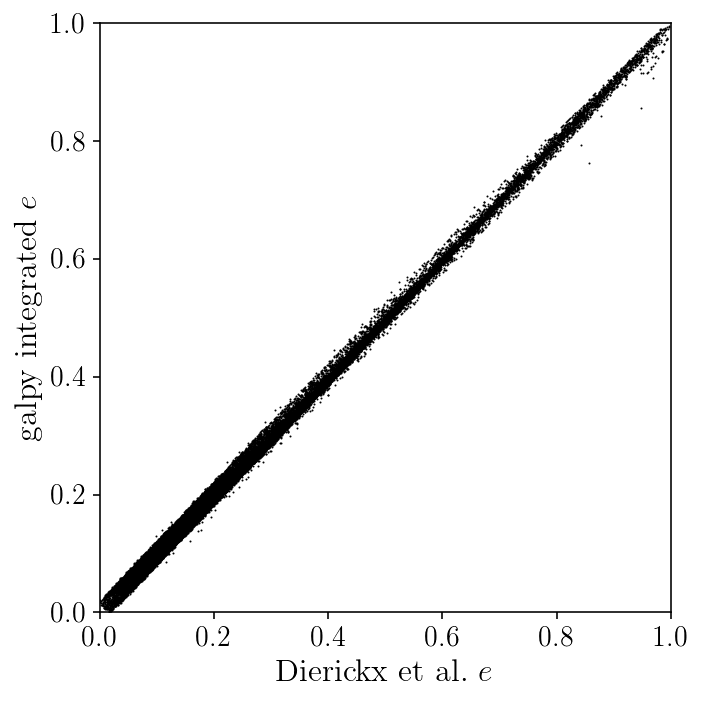

In [57]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.scatter(dierickx['e'], e_int,  s=1, color='Black', lw=0.)
plt.xlabel(r'$\mathrm{Dierickx\ et\ al.}\ e$')
plt.ylabel(r'$\mathrm{galpy\ integrated}\ e$')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
fig.tight_layout()
plt.savefig('../plots/dierickx-integratedee.png', format='png', dpi=200)

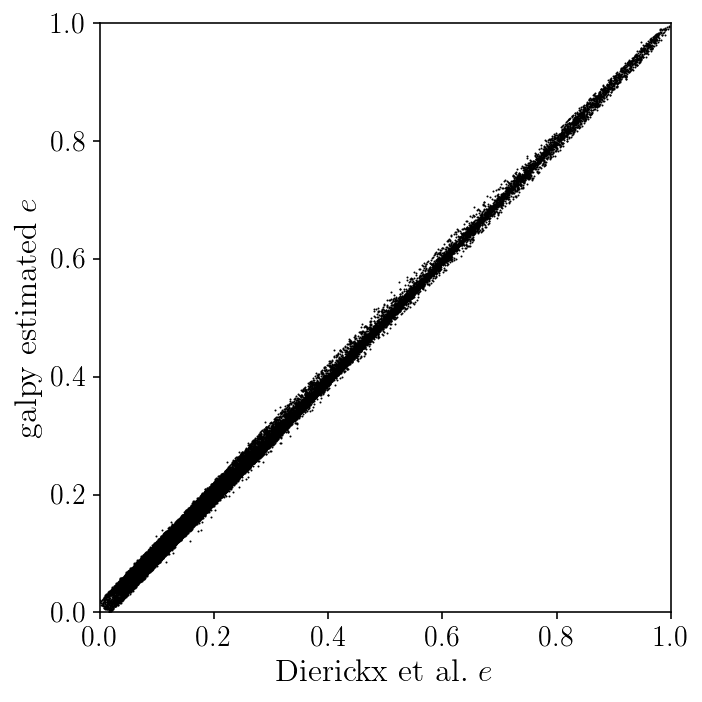

In [59]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.scatter(dierickx['e'], e_ana,  s=1, color='Black', lw=0.)
plt.xlabel(r'$\mathrm{Dierickx\ et\ al.}\ e$')
plt.ylabel(r'$\mathrm{galpy\ estimated}\ e$')
plt.xlim(0.,1.)
plt.ylim(0.,1.)
fig.tight_layout()
plt.savefig('../plots/dierickx-analyticee.png', format='png', dpi=200)

## The Rave-TGAS eccentricity distribution

In [439]:
tgas = gload.tgas()
rave = gload.rave()

In [440]:

m1,m2,sep= xmatch.xmatch(rave,tgas,colRA1='RAdeg', colDec1='DEdeg', colRA2='ra',colDec2='dec',epoch2=2015.)
rave= rave[m1]
tgas= tgas[m2]

In [441]:
vxvv = np.dstack([tgas['ra'], tgas['dec'], 10**((rave['DistanceModulus_Binney']-5)/5)/1e3, tgas['pmra'], tgas['pmra'], rave['HRV']])[0]
ro, vo, zo = 8., 220., 0.025
ra, dec= vxvv[:,0], vxvv[:,1]
lb= bovy_coords.radec_to_lb(ra,dec,degree=True)
pmra, pmdec= vxvv[:,3], vxvv[:,4]
pmllpmbb= bovy_coords.pmrapmdec_to_pmllpmbb(pmra,pmdec,ra,dec,degree=True)
d, vlos= vxvv[:,2], vxvv[:,5]
rectgal= bovy_coords.sphergal_to_rectgal(lb[:,0],lb[:,1],d,vlos,pmllpmbb[:,0], pmllpmbb[:,1],degree=True)

vsolar= np.array([-10.1,4.0,6.7])
vsun= np.array([0.,1.,0.,])+vsolar/vo

X = rectgal[:,0]/ro
Y = rectgal[:,1]/ro
Z = rectgal[:,2]/ro
vx = rectgal[:,3]/vo
vy = rectgal[:,4]/vo
vz = rectgal[:,5]/vo
vsun= np.array([0.,1.,0.,])+vsolar/vo
Rphiz= bovy_coords.XYZ_to_galcencyl(X,Y,Z,Zsun=zo/ro)
vRvTvz= bovy_coords.vxvyvz_to_galcencyl(vx,vy,vz,Rphiz[:,0],Rphiz[:,1],Rphiz[:,2],vsun=vsun,Xsun=1.,Zsun=zo/ro,galcen=True)



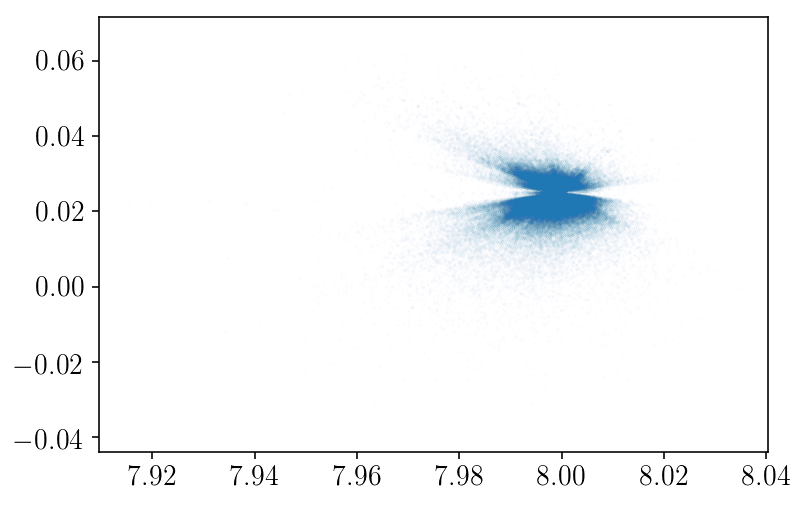

In [466]:
plt.scatter(Rphiz[:,0]*8., Rphiz[:,2]*8., s=0.0001)

In [447]:
%timeit -n 1 deltas = estimateDeltaStaeckel(MWPotential2014, Rphiz[:,0], Rphiz[:,2], no_median=True)
aAS = actionAngleStaeckel(pot=MWPotential2014, delta=0.4, c=True)

1 loop, best of 3: 1min 22s per loop


In [448]:
%timeit -n 2 par = aAS.EccZmaxRperiRap(Rphiz[:,0], vRvTvz[:,0], vRvTvz[:,1], Rphiz[:,2], vRvTvz[:,2], Rphiz[:,1], delta=deltas)

2 loops, best of 3: 21.3 s per loop


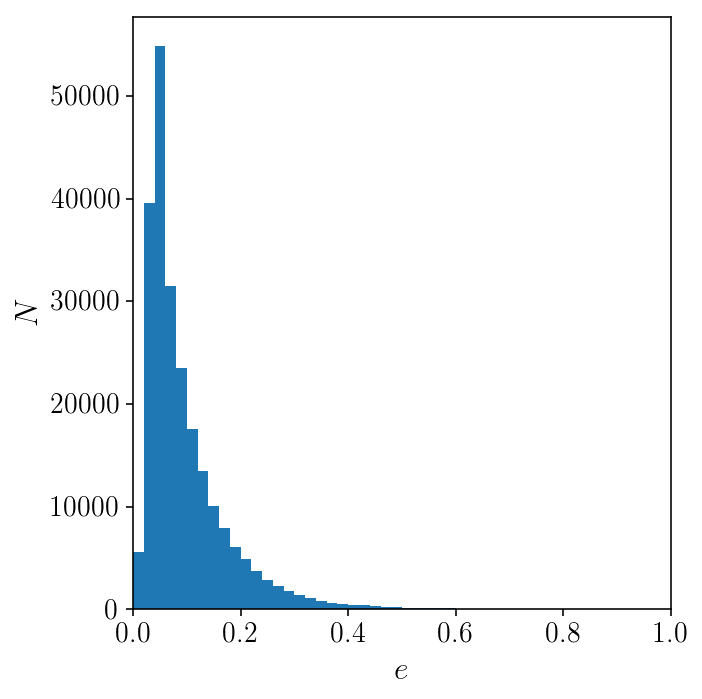

In [456]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)

plt.hist(par[0], range=(0.,1), bins=50)
plt.xlabel(r'$e$')
plt.ylabel(r'$N$')
plt.xlim(0.,1.)

fig.tight_layout()

(-100.0, 100.0)

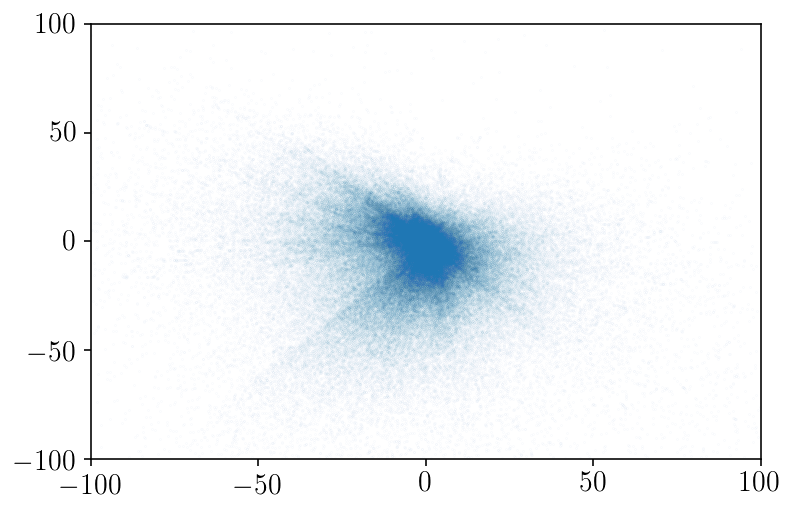

In [469]:
plt.scatter(vx*220.,vy*220.,s=0.0001)
plt.ylim(-100.,100.)
plt.xlim(-100.,100.)

(-100.0, 100.0)

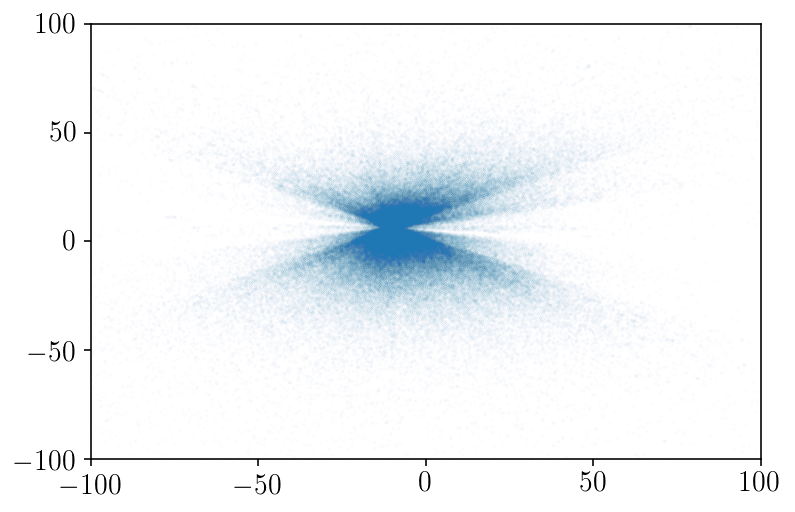

In [467]:
plt.scatter(vRvTvz[:,0]*220.,vRvTvz[:,2]*220.,s=0.0001)
plt.ylim(-100.,100.)
plt.xlim(-100.,100.)

## Timing the estimation along an orbit

In [229]:
mp = MWPotential2014#MiyamotoNagaiPotential(amp=5*10**10*units.Msun,a=3.*units.kpc,b=300.*units.pc)
o= Orbit(vxvv=[1.,0.1,1.1,0.,0.1,0.])
ts= numpy.linspace(0,100,100000)
o.integrate(ts,mp)
aAS= actionAngleStaeckel(pot=mp,delta=0.3) 
R, vR, vT, z, vz, phi = o.getOrbit().T
delta = estimateDeltaStaeckel(mp, R, z, no_median=True)
es, zms, rps, ras = aAS.EccZmaxRperiRap(R,vR,vT,z,vz,phi,delta=delta)

In [223]:
from galpy.actionAngle import actionAngleStaeckelGrid
o= Orbit(vxvv=[1.,0.1,1.1,0.,0.1,0.])
ts= numpy.linspace(0,100,100000)
o.integrate(ts,mp)
aASG= actionAngleStaeckelGrid(pot=mp,delta=0.4,nE=51,npsi=51,nLz=61,c=True,interpecc=True)
R, vR, vT, z, vz, phi = o.getOrbit().T
#delta = estimateDeltaStaeckel(mp, R, z, no_median=True)

es, zms, rps, ras =aASG.EccZmaxRperiRap(R,vR,vT,z,vz,phi)

In [204]:
%timeit o.e(analytic=True, c=False)

1000 loops, best of 3: 5.45 ms per loop


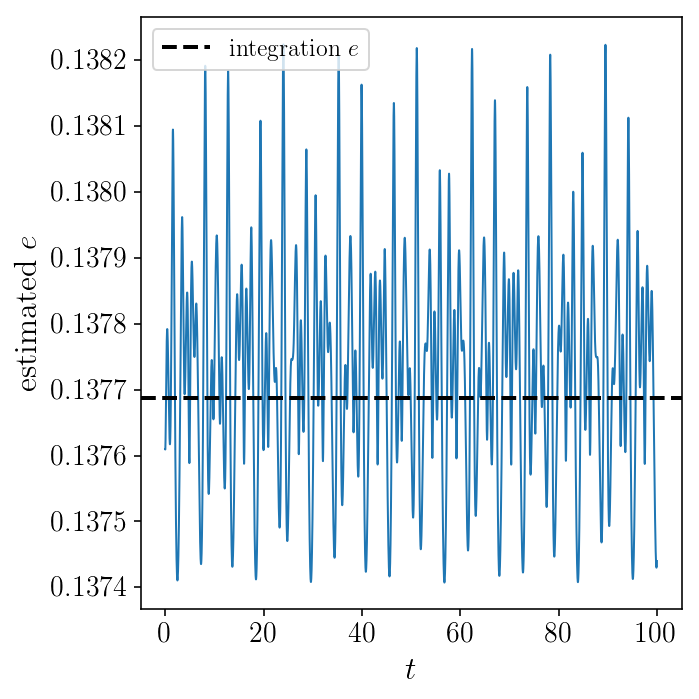

In [233]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.plot(ts, es)
plt.axhline(o.e(analytic=False), lw=2., color='Black', linestyle='dashed', label=r'$\mathrm{integration}\ e$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathrm{estimated}\ e$')
fig.tight_layout()
plt.legend(fontsize='large')
plt.savefig('../plots/lp-orbit-integration-et.png', dpi=200)

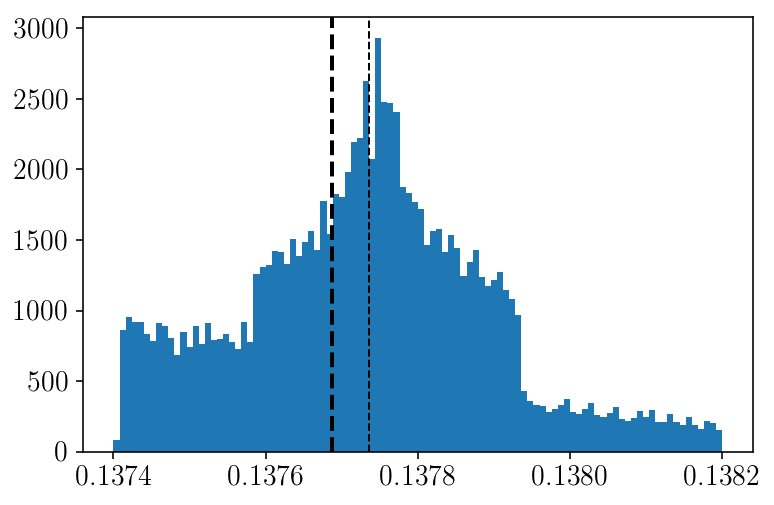

In [242]:
plt.hist(es, range=(0.1374,0.1382), bins=100)
plt.axvline(o.e(analytic=False), lw=2., color='Black', linestyle='dashed', label=r'$\mathrm{integration}\ e$')
plt.axvline(np.nanmedian(es), lw=1., color='Black', linestyle='dashed', label=r'$\mathrm{integration}\ e$')




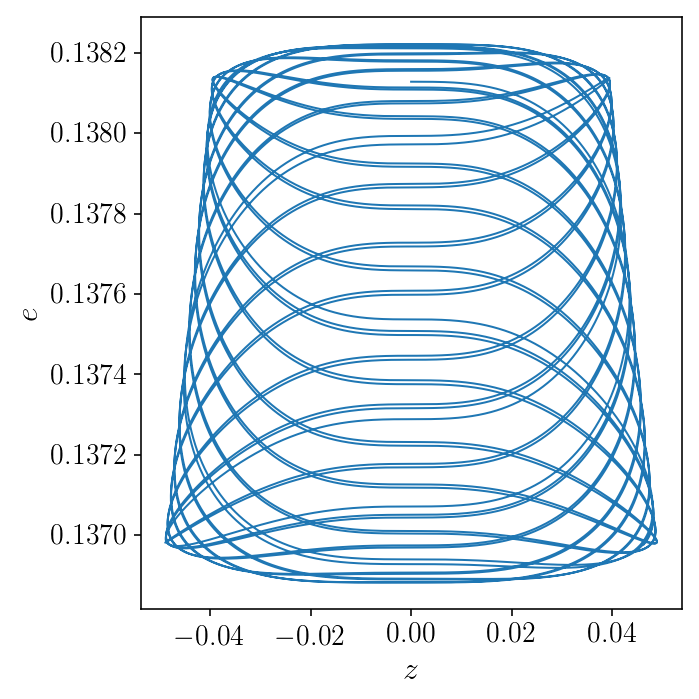

In [227]:
fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*columnwidth)
plt.plot(z, es)
plt.xlabel(r'$z$')
plt.ylabel(r'$e$')
fig.tight_layout()
#plt.savefig('../plots/lp-orbit-integration-et.png', dpi=200)

In [167]:
%%timeit -n 10
es, zms, rps, ras = aAS.EccZmaxRperiRap(R, vR, vT, z, vz, phi,delta=delta)

10 loops, best of 3: 29.7 ms per loop


## Looking at delta as a function of R and z

In [47]:
rzgrid = np.mgrid[0.:10.:100j, -10.:10.:100j]
deltgrid = estimateDeltaStaeckel(MWPotential2014, rzgrid[0].ravel()/8., rzgrid[1].ravel()/8., no_median=True)

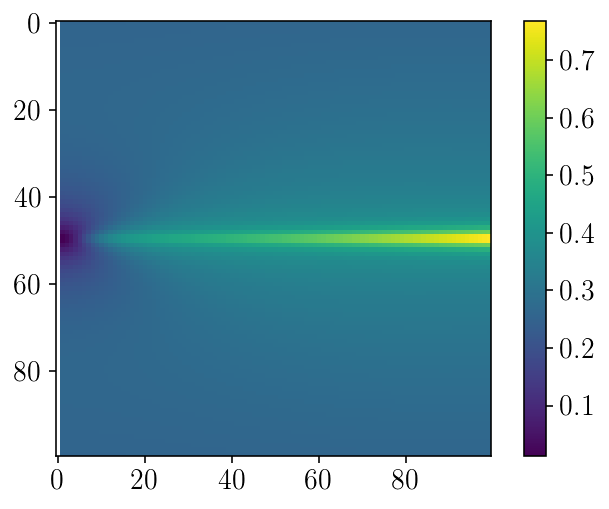

In [49]:
plt.imshow(np.rot90(deltgrid.reshape(100,100)))
plt.colorbar()

In [436]:
rgrid = np.linspace(0.001,3.,100)
zgrid = np.ones(100)*0.1
deltas = estimateDeltaStaeckel(MWPotential2014, rgrid, zgrid, no_median=True)

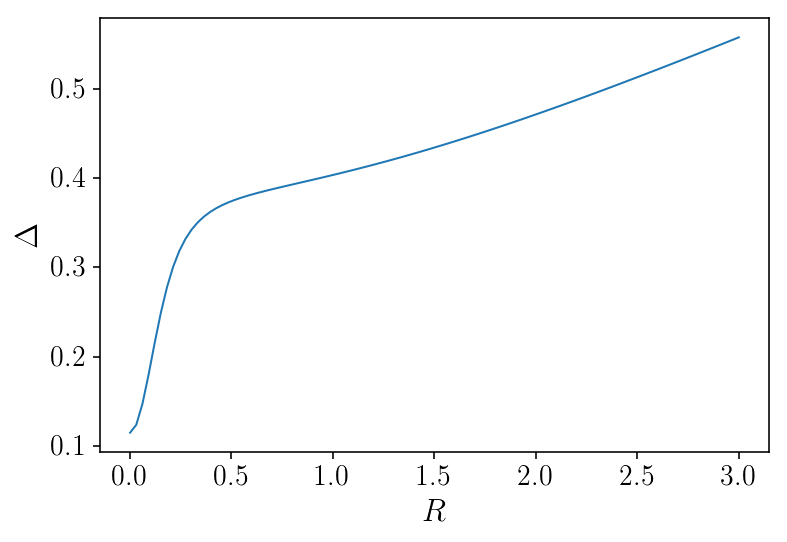

In [438]:
plt.plot(rgrid, deltas)
plt.ylabel(r'$\Delta$')
plt.xlabel(r'$R$')

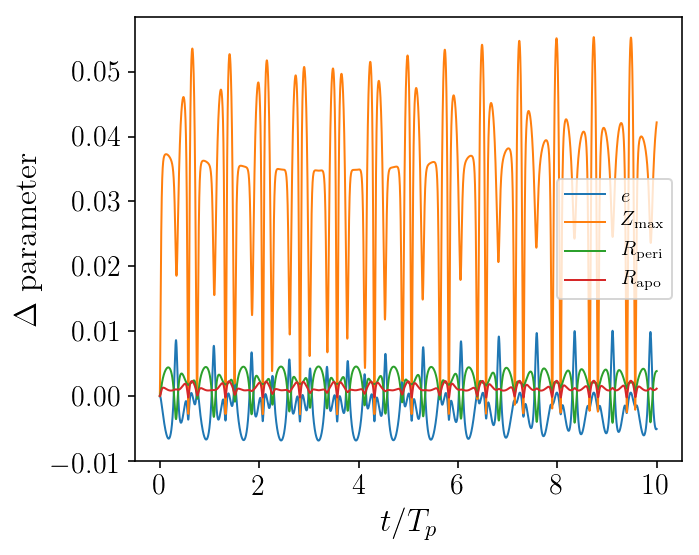

In [476]:
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,c=True)
_,_,_,_,_,Oz= aAS.actionsFreqs(o)
Tz = 2*np.pi/Oz

Tp = orbit_helper.azimuthal_period(o, pot=MWPotential2014, delta=est_delta)
    
ts= numpy.arange(0.,10.*Tp,0.001)
t = orbit_helper.params_along_orbit(o, ts, delta='along')

fig = plt.figure()
fig.set_size_inches(1.5*columnwidth, 1.5*0.8*columnwidth)

labels = [r'$e$', r'$Z_{\mathrm{max}}$', r'$R_{\mathrm{peri}}$', r'$R_{\mathrm{apo}}$']
for i in range(len(t)):
    pao = (t[i]-t[i][0])/t[i][0]
    plt.plot(ts/Tp,pao, label=labels[i])
plt.legend()
plt.xlabel(r'$t/T_{p}$')
plt.ylabel(r'$\Delta\ \mathrm{parameter}$')
fig.tight_layout()